# Classification. Linear models and KNN

In [843]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [844]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(1.75 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [845]:
from sklearn.exceptions import NotFittedError

In [1062]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_dict={}
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        x_dot_weights = np.matmul(X, weights) 
        return 1 / (1 + np.exp(-x_dot_weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        exp=np.exp(-(x@weights)*y)
        return np.sum(np.log(1+exp))/len(x)+np.mean(np.abs(weights))/2*self.C
        
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
      

        for i in range(self.max_iter):
            x_dot_weights=np.matmul(self.weights_,X_ext.T)


            delta = np.sum(X_ext.T*y*(1-1/(1+np.exp(-x_dot_weights*y))),axis=1)/len(X_ext)-abs(self.weights_)/self.C
            # prev_weights=self.weights_
            # self.weights_+=delta

            self.weights_ += self.eta * delta
            self.loss_dict[i]=self.get_loss(X_ext,self.weights_,y)
            if np.all(delta<self.tol):
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_[1:])
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return [1 if p > 0.5 else -1 for p in self.get_sigmoid(X, self.weights_[1:])]

In [847]:
from sklearn import datasets
from sklearn import metrics

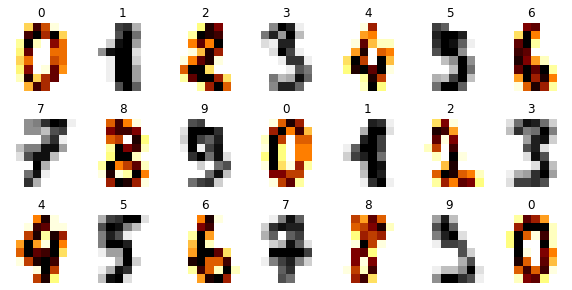

In [1063]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [1064]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [1065]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [851]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [852]:
lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1]))

array([0.58661758, 0.40131234])

In [853]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [854]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)
lr_clf.fit(X_train, y_train)
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [855]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [856]:
model = CustomLogisticRegression()

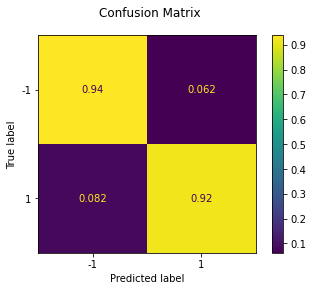

In [857]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [858]:
train_acc, test_acc

(0.906054279749478, 0.9277777777777778)

In [859]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

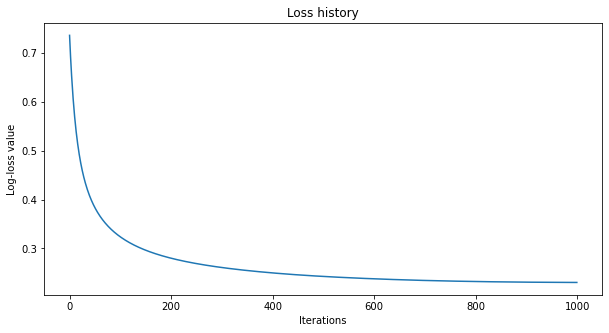

In [860]:
plt.figure(figsize=(10,5))
plt.title('Loss history')
plt.xlabel('Iterations')
plt.ylabel('Log-loss value')
plt.plot(model.loss_dict.values())

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [861]:
losses_dict={}
rates=np.round(np.arange(0.0005,0.003,0.0003),4)
for i in rates:
    lr_clf = CustomLogisticRegression(eta=i)
    lr_clf.fit(X_train, y_train)
    losses_dict['Learning rate: '+str(i)]=lr_clf.loss_dict


<AxesSubplot:>

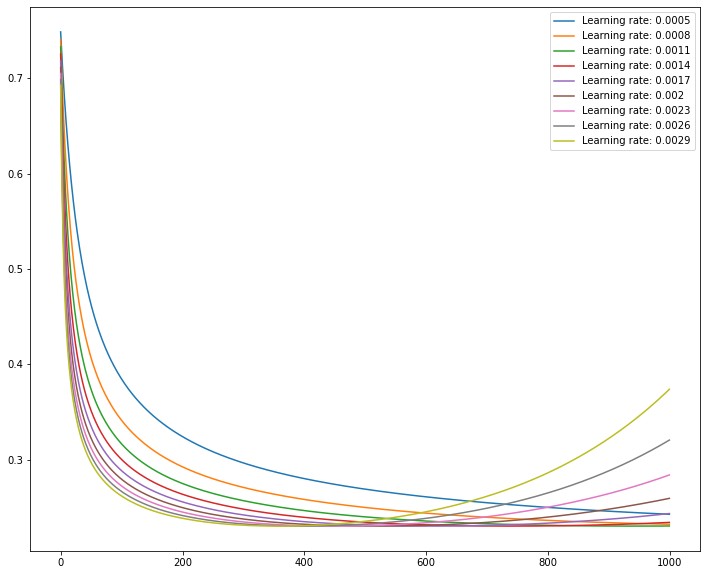

In [862]:
pd.DataFrame(losses_dict).plot(figsize=(12,10))

< your thoughts >

Видно что с ростом learning rate растет скорость снижения log-loss value на начальных итерациях. Но так же с ростом learning rate на последних итерация лосс-функция наоборот растет. Это связано с тем что с ростом learning rate увеличивается шаг градиентного спуска, в результате чего в процессе градиентного спуска перешагивается точка минимума и loss начинает расти с каждой итерацией.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [863]:
def fit_evaluate_mod(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    # disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    # disp.figure_.suptitle("Confusion Matrix")
    # plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)


train_acc_dict=[]
test_acc_dict=[]
regs=np.round(np.arange(0.3,10,0.01),4)
for i in regs:
    model = CustomLogisticRegression(C=i)
    train_acc, test_acc = fit_evaluate_mod(model, X_train, y_train, X_test, y_test)
    test_acc_dict.append(test_acc)
    train_acc_dict.append(train_acc)

< your thoughts >

([<matplotlib.axis.XTick at 0x25fe7533b80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

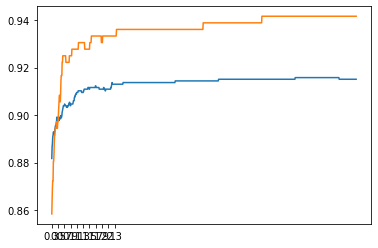

In [864]:
plt.plot(regs,train_acc_dict)
plt.plot(regs,test_acc_dict)
plt.xticks(np.arange(0.3,2.5,0.2))


**(0.25 points)** Compare zero initialization and random initialization. 

In [865]:
## your code

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [866]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.

        """
        n = X.shape[0]
        k = Y.shape[0]
        X_dots = (X*X).sum(axis=1).reshape((n,1))*np.ones(shape=(1,k))
        Y_dots = (Y*Y).sum(axis=1)*np.ones(shape=(n,1))
        D_squared =  X_dots + Y_dots -2*X.dot(Y.T)
        return np.sqrt(D_squared)
        

    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
       
  
       
        return np.asarray([np.sum(weights[y==unq]) for unq in self.classes_])
        # pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
   
            if self.weights == 'distance':
                weights_of_points = 1/(P+np.finfo(np.float64).eps)

            weights_of_classes=np.zeros((0,len(self.classes_)))

      

            for i in range(0,len(X)):
                dist = np.argsort(P[i])
                temp_weights=self.get_class_weights(self.y[dist][:self.n_neighbors],weights_of_points[i][dist][:self.n_neighbors])
                # print(temp_weights)
                temp_weights=temp_weights/np.sum(temp_weights)
                weights_of_classes=np.vstack((weights_of_classes,temp_weights))

            # weights_of_classes = self.get_class_weights(np.argsort(weights_of_points),weights_of_points)
                
            # dist = np.argsort(P)[:self.n_neighbors]
            # vals,counts = np.unique(dist, return_counts=True)

        
            return weights_of_classes
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """

        P = self.get_pairwise_distances(X, self.points)
        
        weights_of_points = np.ones(P.shape)

        if self.weights == 'distance':
            weights_of_points = 1/(P+np.finfo(np.float64).eps)

        preds=[]



        for i in range(0,len(X)):
            dist = np.argsort(P[i])
            temp_weights=self.get_class_weights(self.y[dist][:self.n_neighbors],weights_of_points[i][dist][:self.n_neighbors])
            # print(temp_weights)
            temp_weights=temp_weights/np.sum(temp_weights)
            preds.append(self.classes_[np.argmax(temp_weights)])

        # weights_of_classes = self.get_class_weights(np.argsort(weights_of_points),weights_of_points)
            
        # dist = np.argsort(P)[:self.n_neighbors]
        # vals,counts = np.unique(dist, return_counts=True)

        return preds
        
        
            

In [867]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [868]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [869]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

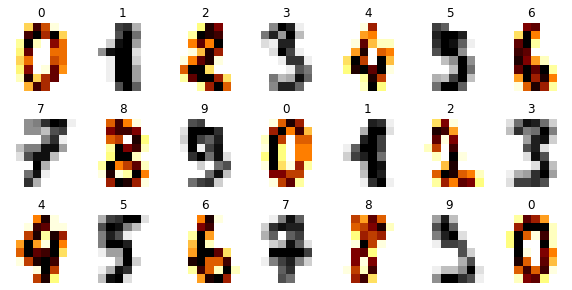

In [870]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [871]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [872]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

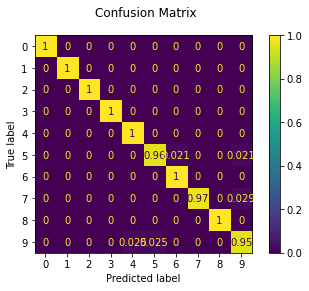

In [873]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [874]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

9-ка путается с 4-кой,5-кой и 7-кой, кроме того с 5-кой иногда путает 6-ку. Все дело в схожести написания, так как различия между ними могут быть иногда в паре пикселей. 

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

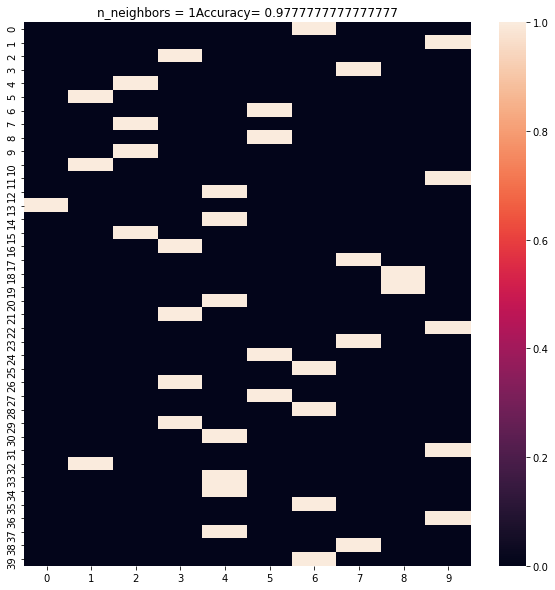

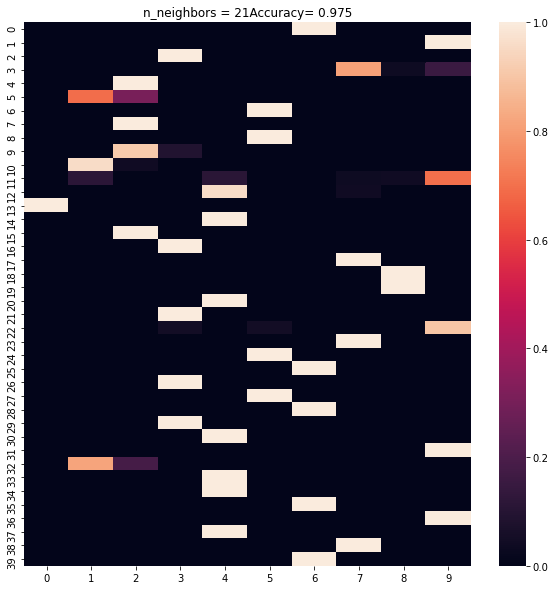

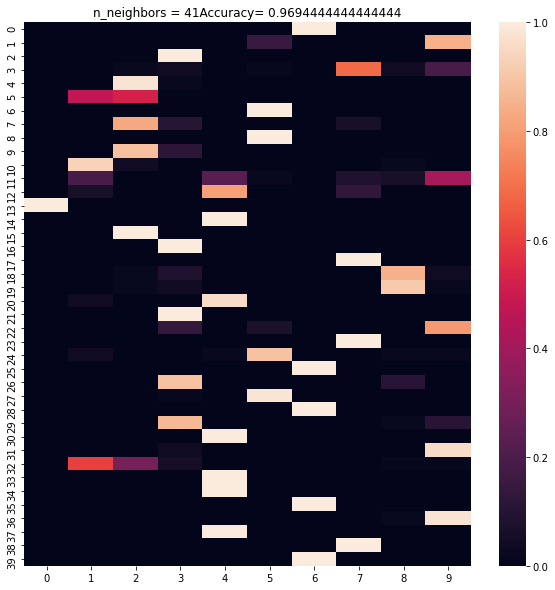

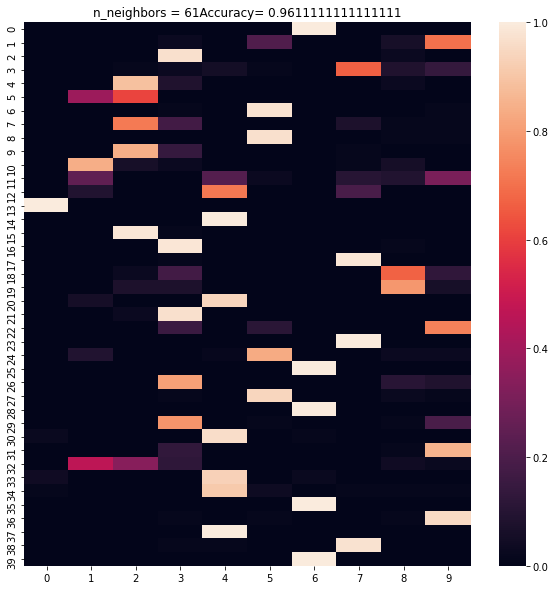

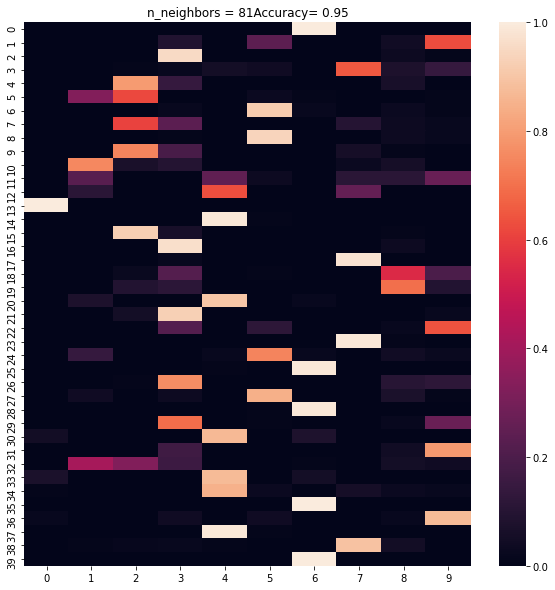

In [875]:
for i in range(1,101,20):

    model = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
    model.fit(X_train, y_train)
    probs=model.predict_proba(X_test[:40])
    train_acc, test_acc = fit_evaluate_mod(model, X_train, y_train, X_test[:], y_test[:])
    plt.figure(figsize=(10,10))
    plt.title('n_neighbors = '+str(i)+'Accuracy= '+str(test_acc))
    
    sns.heatmap(probs)

Увеличение n_neighbours размазывает вероятности между классами в каждом отдельном наблюдении тестовой выборки, что с одной стороны делае предсказание менее увереннымб но с другой строгны помогает модели обобщать выводы. При этом крайние значения n_neighbours сказываются на accuracy (при маленьких значениях knn модель неустойчива к выбросам, при больших слишком обобщает) </br>
P.S. на хитмапах отражена только часть output probabilities для большей наглядности "размытия" вероятностей

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

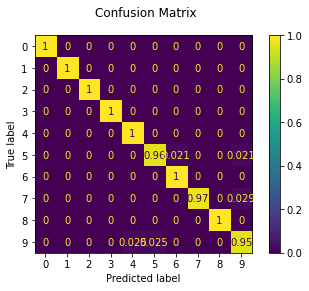

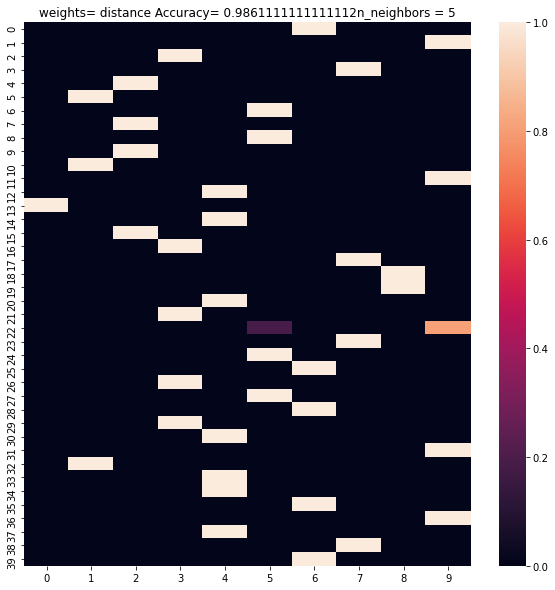

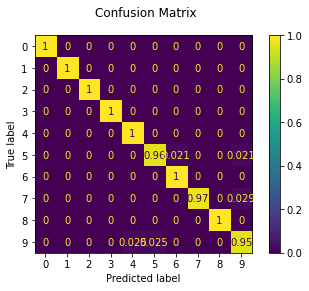

<AxesSubplot:title={'center':'weights= uniform Accuracy= 0.9861111111111112n_neighbors = 5'}>

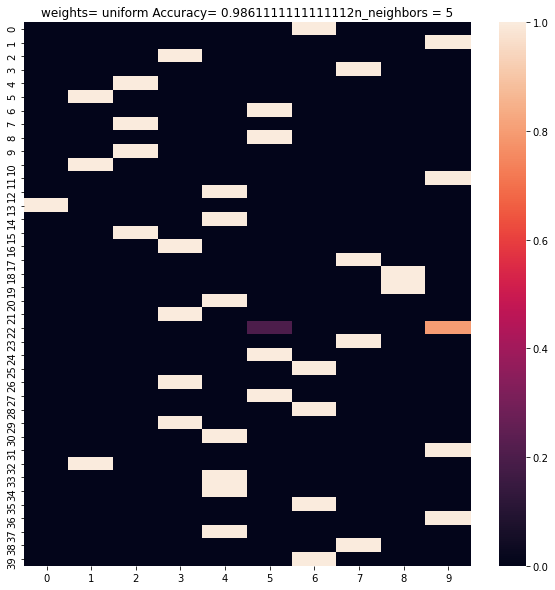

In [876]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
probs=model.predict_proba(X_test[:40])
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test[:], y_test[:])
plt.figure(figsize=(10,10))
plt.title('weights= distance '+'Accuracy= '+str(test_acc)+'n_neighbors = '+str(model.n_neighbors))
sns.heatmap(probs)

model = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
probs=model.predict_proba(X_test[:40])
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test[:], y_test[:])
plt.figure(figsize=(10,10))
plt.title('weights= uniform '+'Accuracy= '+str(test_acc)+'n_neighbors = '+str(model.n_neighbors))
sns.heatmap(probs)

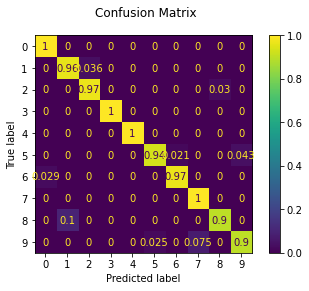

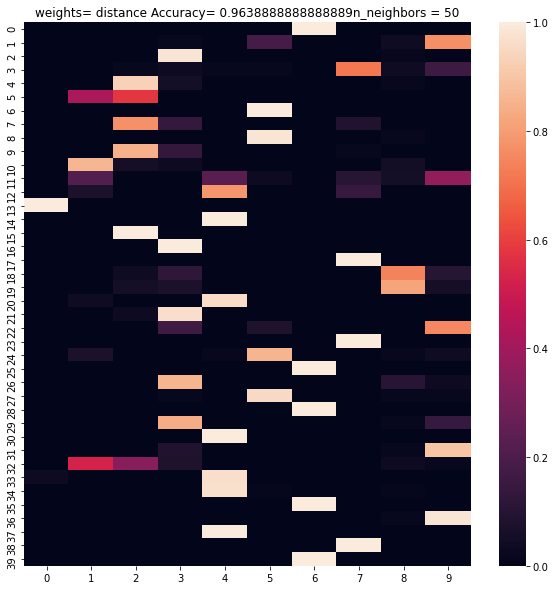

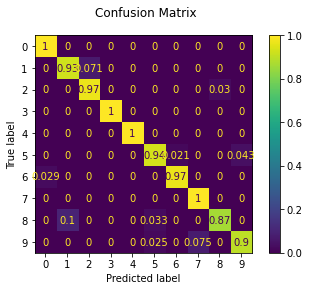

<AxesSubplot:title={'center':'weights= uniform Accuracy= 0.9583333333333334n_neighbors = 50'}>

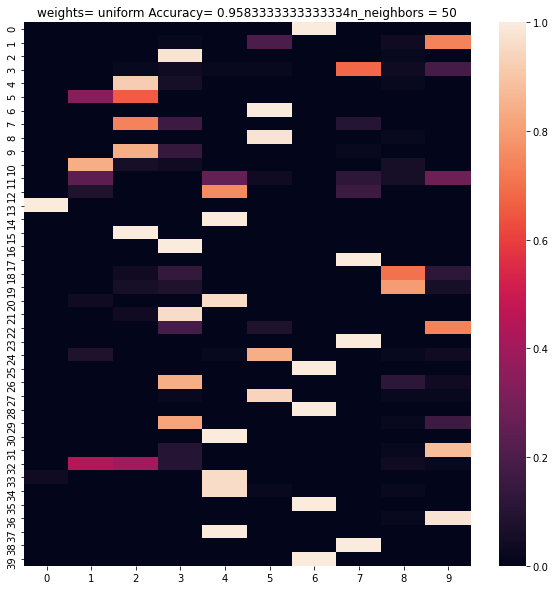

In [877]:
model = CustomKNeighborsClassifier(n_neighbors=50, weights='distance')
model.fit(X_train, y_train)
probs=model.predict_proba(X_test[:40])
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test[:], y_test[:])
plt.figure(figsize=(10,10))
plt.title('weights= distance '+'Accuracy= '+str(test_acc)+'n_neighbors = '+str(model.n_neighbors))
sns.heatmap(probs)

model = CustomKNeighborsClassifier(n_neighbors=50, weights='uniform')
model.fit(X_train, y_train)
probs=model.predict_proba(X_test[:40])
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test[:], y_test[:])
plt.figure(figsize=(10,10))
plt.title('weights= uniform '+'Accuracy= '+str(test_acc)+'n_neighbors = '+str(model.n_neighbors))
sns.heatmap(probs)

Как видно из графиков выше, на малых n_neighbors обе модели перформят практически идентично. Но с ростом n_neighbors модель uniform начинает проигрывать в точности, в ее confusion matrix появляются новые классы, между которыми появляется взаимная путаница. 
Однако, предположу, что для для шумных данных взвешивание может приводить к нежелаемым ошибкам. Однако оно, в свою очередь помогает бороться с неравномерностью частоты встречаемости классов в обучающей выборке.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it

В задачах прогнозов осложений течения заюолевания, на основании данных истории болезни с большим количеством категориальных признаков может лучше подойти  Hamming Distance

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [887]:
PATH = "data"

In [1096]:
df = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [950]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

% of women survived:  0.7115253155903933
% of men survived:    0.20579534519014864


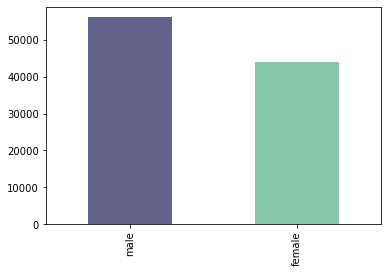

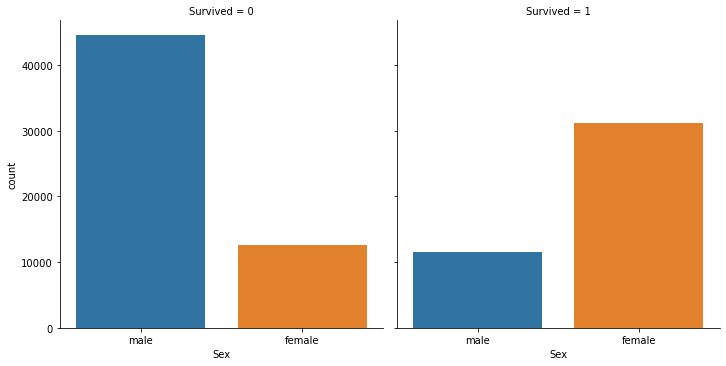

In [923]:
d=df.Sex.value_counts()
d.plot(kind='bar', color=["#3f3e6fd1", "#85c6a9"], stacked='True')
df.groupby(['Survived','Sex'])['Survived'].count()
sns.catplot(x='Sex', col='Survived', kind='count', data=df)
labels = (df['Survived'].value_counts()/100000*100)
for i, v in enumerate(labels):
    ax.text(i, v-40, str(v)+' %', horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
print("% of women survived: " , df[df.Sex == 'female'].Survived.sum()/df[df.Sex == 'female'].Survived.count())
print("% of men survived:   " , df[df.Sex == 'male'].Survived.sum()/df[df.Sex == 'male'].Survived.count())

Women were more likely to survive than men

74 % of women survived but only 19% of men (in training set)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

C:\Users\u.username\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,count,mean,std,min,25%,50%,75%,max
Age,96708.0,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0


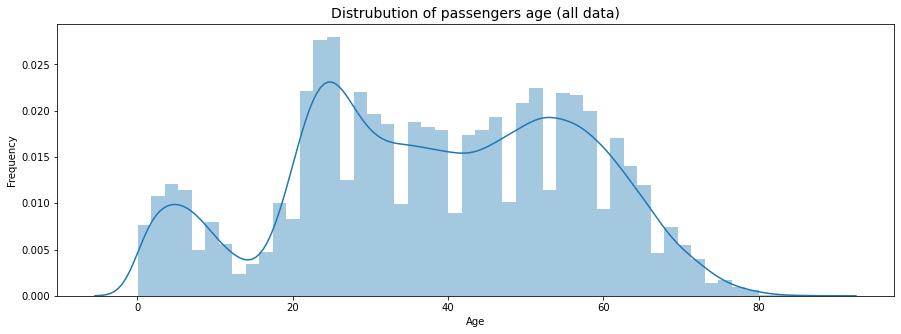

In [924]:
plt.figure(figsize=(15, 5))
sns.distplot(df["Age"])
plt.title('Distrubution of passengers age (all data)',fontsize= 14)
plt.xlabel('Age')
plt.ylabel('Frequency')
age_distr = pd.DataFrame(df['Age'].describe())
# Transpose index and columns.
age_distr.transpose()

The distribution of Age is slightly right skewed. The Age vary from about 0.08 year to 87 years with mean = 38.36.< your thoughts >

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


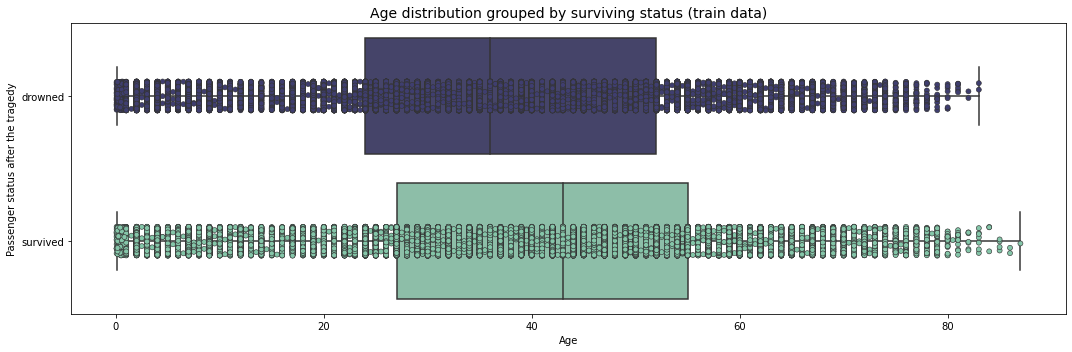

In [925]:
plt.figure(figsize=(15, 5))

# Draw a box plot to show Age distributions with respect to survival status.
sns.boxplot(y = 'Survived', x = 'Age', data =df,
     palette=["#3f3e6fd1", "#85c6a9"], fliersize = 0, orient = 'h')

# Add a scatterplot for each category.
sns.stripplot(y = 'Survived', x = 'Age', data =df,
     linewidth = 0.6, palette=["#3f3e6fd1", "#85c6a9"], orient = 'h')

plt.yticks( np.arange(2), ['drowned', 'survived'])
plt.title('Age distribution grouped by surviving status (train data)',fontsize= 14)
plt.ylabel('Passenger status after the tragedy')
plt.tight_layout()
pd.DataFrame(df.groupby('Survived')['Age'].describe())


It looks like there is a slightly bigger chance to survive for older people.The mean age of survived passenger is 40.56 which on 2.36 higher than the mean age of drowned passengers.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

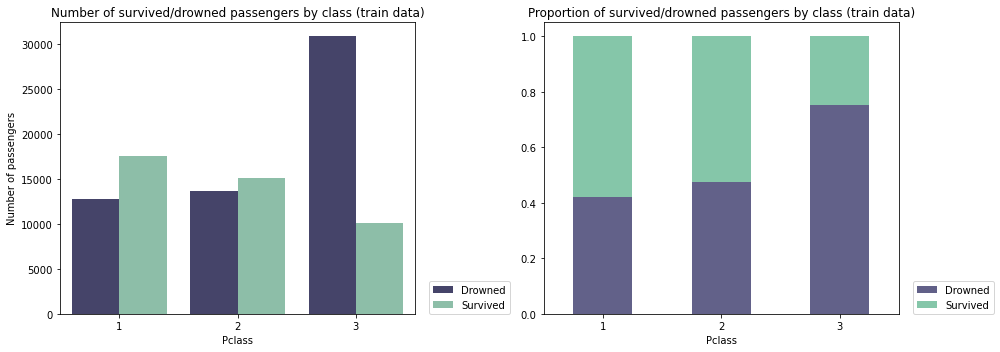

In [926]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(121)
sns.countplot(x = 'Pclass', hue = 'Survived', data = df, palette=["#3f3e6fd1", "#85c6a9"], ax = ax1)
plt.title('Number of survived/drowned passengers by class (train data)')
plt.ylabel('Number of passengers')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)

ax2 = fig.add_subplot(122)
d = df.groupby('Pclass')['Survived'].value_counts(normalize = True).unstack()
d.plot(kind='bar', stacked='True', ax = ax2, color =["#3f3e6fd1", "#85c6a9"])
plt.title('Proportion of survived/drowned passengers by class (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)

plt.tight_layout()

According to the distribution, first class has the largest number of survivors. There is a trend od decreasing survival rate with the decresing of the class.

C:\Users\u.username\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


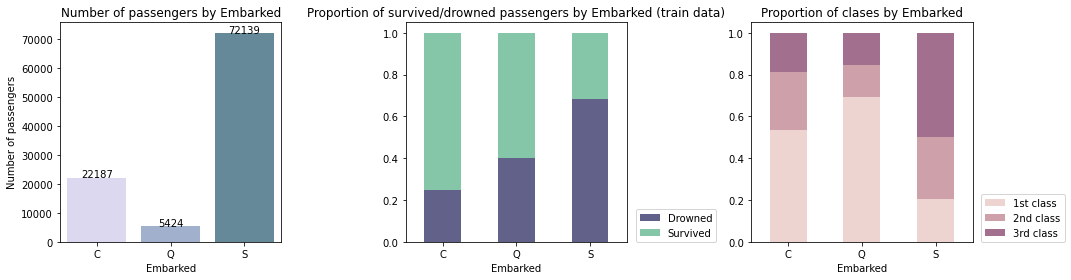

In [995]:

fig = plt.figure(figsize = (15,4))

ax1 = fig.add_subplot(131)
palette = sns.cubehelix_palette(5, start = 2)
ax = sns.countplot(df['Embarked'], palette = palette, order = ['C', 'Q', 'S'], ax = ax1)
plt.title('Number of passengers by Embarked')
plt.ylabel('Number of passengers')

# calculate passengers for each category
labels = (df['Embarked'].value_counts())
labels = labels.sort_index()
# add result numbers on barchart
for i, v in enumerate(labels):
    ax.text(i, v+10, str(v), horizontalalignment = 'center', size = 10, color = 'black')
    

ax2 = fig.add_subplot(132)
surv_by_emb = df.groupby('Embarked')['Survived'].value_counts(normalize = True)
surv_by_emb = surv_by_emb.unstack().sort_index()
surv_by_emb.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax2)
plt.title('Proportion of survived/drowned passengers by Embarked (train data)')
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
_ = plt.xticks(rotation=False)


ax3 = fig.add_subplot(133)
class_by_emb = df.groupby('Embarked')['Pclass'].value_counts(normalize = True)
class_by_emb = class_by_emb.unstack().sort_index()
class_by_emb.plot(kind='bar', stacked='True', color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax3)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
plt.title('Proportion of clases by Embarked')
_ = plt.xticks(rotation=False)

plt.tight_layout()

Most number of passengers were embarked in Southampton. Also Southampton has the biggiest proportion of drowned passengers.
More than 50% of embarked in Cherbourd and Queenstown are survied. Also, the majority of embarked here were from first class.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

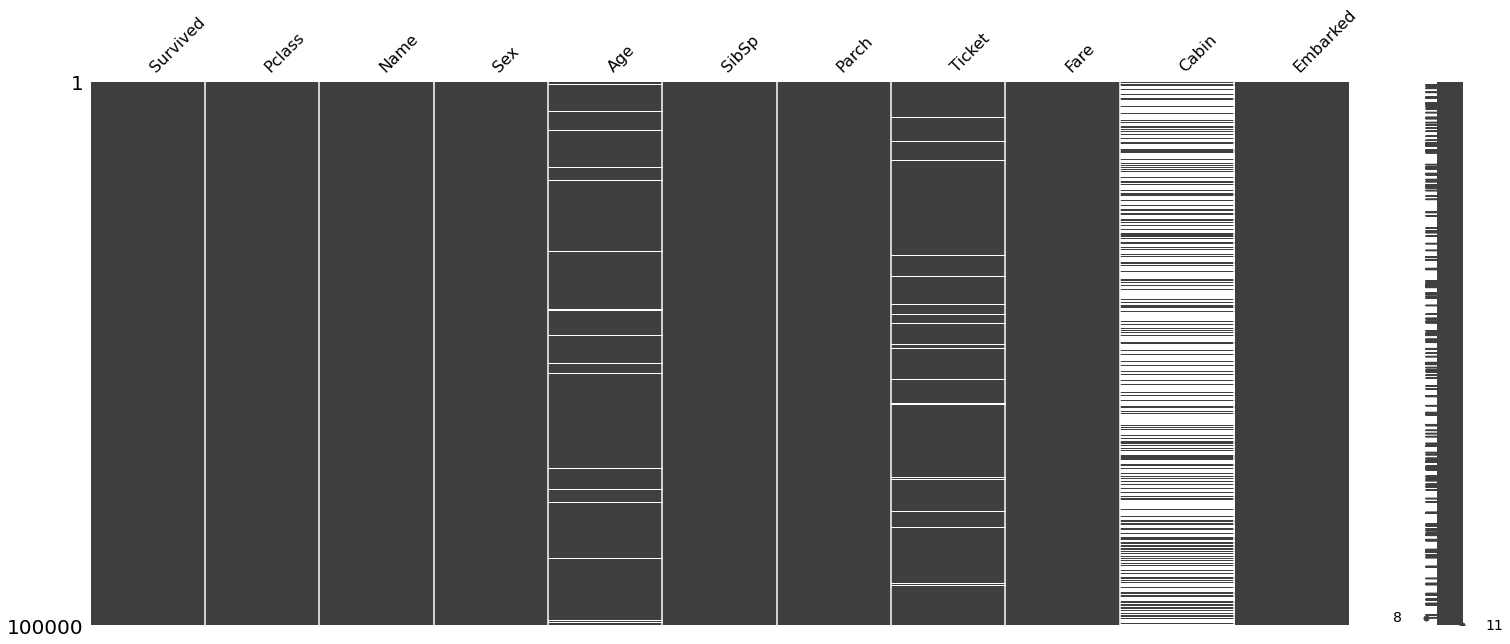

In [1051]:
import missingno as msno
msno.matrix(df)
(pd.isna(df).sum()/len(df))*100

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Для Age и Fare вполне подойдет замена выпавших значений средним. Для Embarked подойдет замена самым частым значением, для простоты. Интереснее с Cabin. Во-первых самым важным информационно для Cabin выглядит первая буква билета, определяющая палубу.

Unique deck letters from the cabin numbers: ['C' nan 'A' 'D' 'B' 'E' 'F' 'G' 'T']


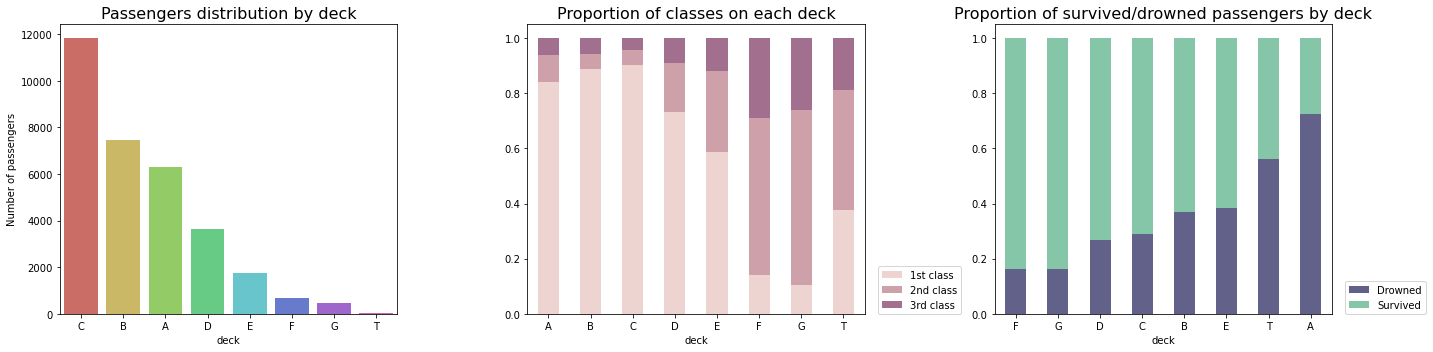

In [1097]:
df['deck'] = df['Cabin'].str.split('', expand = True)[1]
df['family_size'] = df['SibSp'] + df['Parch'] + 1
# df.loc[df['deck'].isna(), 'deck'] = 'U'
print('Unique deck letters from the cabin numbers:', df['deck'].unique())
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(131)
sns.countplot(x = 'deck', data = df, palette = "hls", order = df['deck'].value_counts().index, ax = ax1)
plt.title('Passengers distribution by deck',fontsize= 16)
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(132)
deck_by_class = df.groupby('deck')['Pclass'].value_counts(normalize = True).unstack()
deck_by_class.plot(kind='bar', stacked='True',color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax2)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
plt.title('Proportion of classes on each deck',fontsize= 16)
plt.xticks(rotation = False)

ax3 = fig.add_subplot(133)
deck_by_survived = df.groupby('deck')['Survived'].value_counts(normalize = True).unstack()
deck_by_survived = deck_by_survived.sort_values(by = 1, ascending = False)
deck_by_survived.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax3)
plt.title('Proportion of survived/drowned passengers by deck',fontsize= 16)
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
plt.xticks(rotation = False)
plt.tight_layout()

plt.show()

Для Cabin можно предложить 2 отдельных подхода, во-первых генерация новой фичи на основании самого присутствия/отсутствия информации. Во-вторых заполнения пропущенных значений с использованием метода k-ближайших соседей (KNNImputer) на основании fare, Pclass и Embarked.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Embarked       0.0
deck           0.0
family_size    0.0
dtype: float64

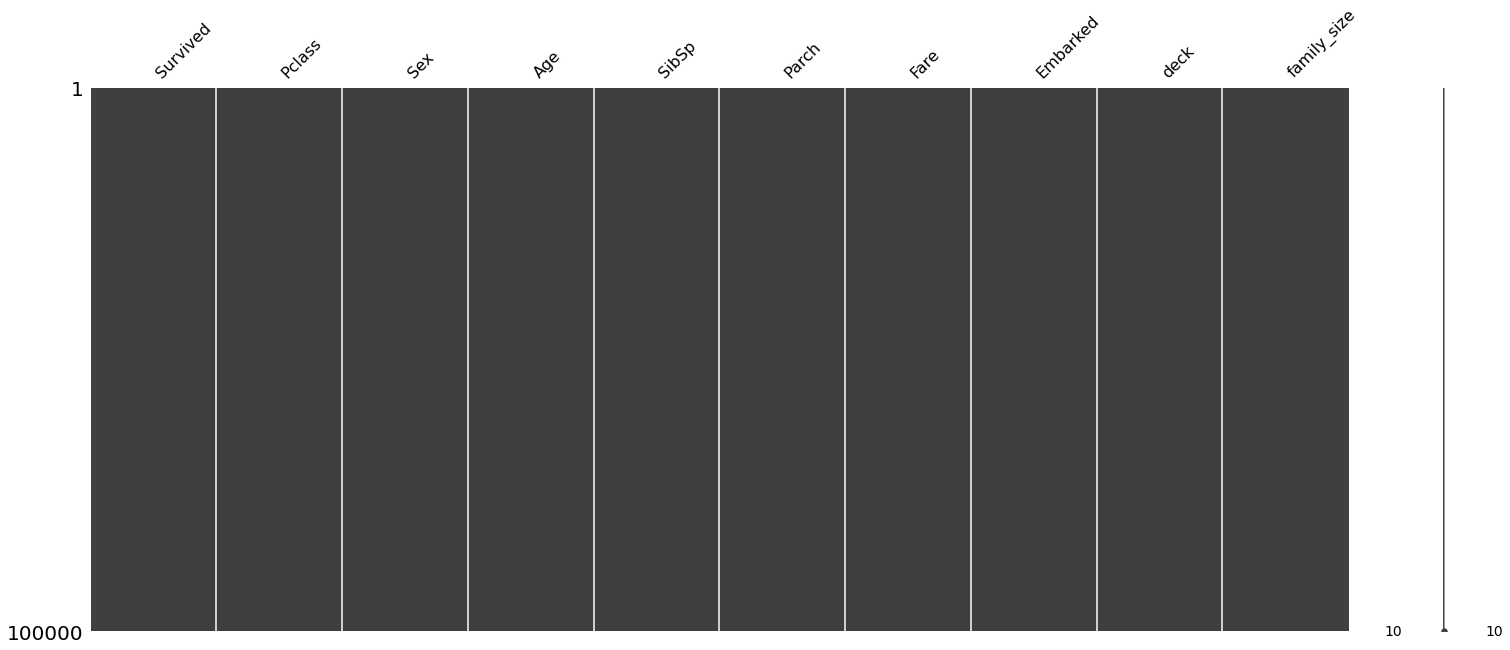

In [1100]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')


df['Age']=df['Age'].fillna(df['Age'].mean())
df['Fare']=df['Fare'].fillna(df['Fare'].mean())
df['Embarked']=imputer.fit_transform(df)[:,-2]

df=df.drop(columns=['Ticket', 'Cabin','Name'])
msno.matrix(df)
df.head()

(pd.isna(df).sum()/len(df))*100

In [1101]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sex']=le.fit_transform(df.Sex)
df['Embarked']=le.fit_transform(df.Embarked)
df['deck']=le.fit_transform(df.deck)
# from sklearn.impute import KNNImputer
# impute_knn = KNNImputer(missing_values=8,n_neighbors=2)
# le.fit
# tepdf=df[['Pclass','Embarked','deck']]
# impute_knn.fit(tepdf)
# df.deck=impute_knn.transform(tepdf)[:,-1]


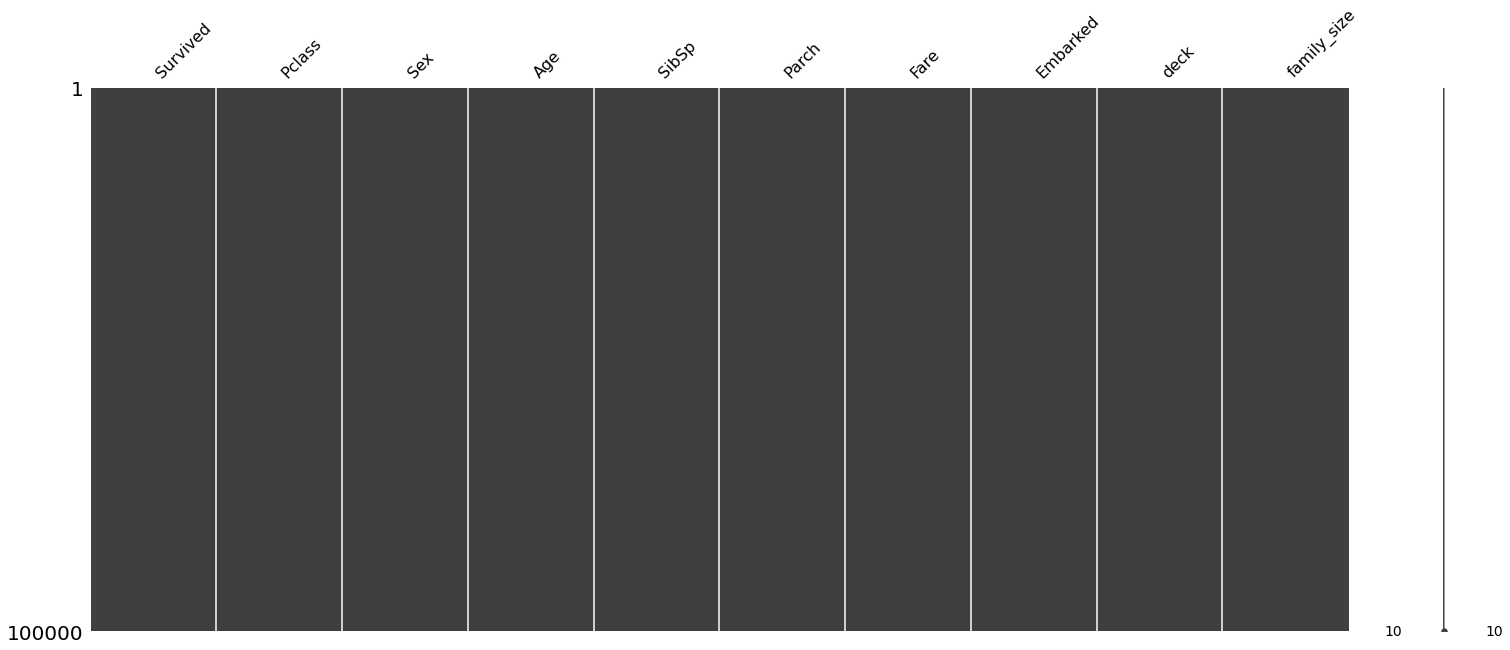

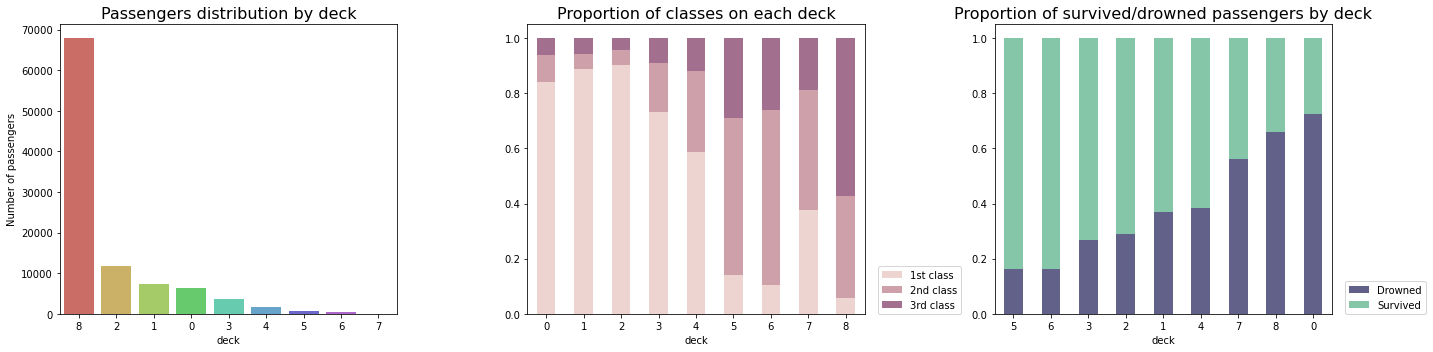

In [1102]:
msno.matrix(df)
df.deck
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
sns.countplot(x = 'deck', data = df, palette = "hls", order = df['deck'].value_counts().index, ax = ax1)
plt.title('Passengers distribution by deck',fontsize= 16)
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(132)
deck_by_class = df.groupby('deck')['Pclass'].value_counts(normalize = True).unstack()
deck_by_class.plot(kind='bar', stacked='True',color = ['#eed4d0', '#cda0aa', '#a2708e'], ax = ax2)
plt.legend(('1st class', '2nd class', '3rd class'), loc=(1.04,0))
plt.title('Proportion of classes on each deck',fontsize= 16)
plt.xticks(rotation = False)

ax3 = fig.add_subplot(133)
deck_by_survived = df.groupby('deck')['Survived'].value_counts(normalize = True).unstack()
deck_by_survived = deck_by_survived.sort_values(by = 1, ascending = False)
deck_by_survived.plot(kind='bar', stacked='True', color=["#3f3e6fd1", "#85c6a9"], ax = ax3)
plt.title('Proportion of survived/drowned passengers by deck',fontsize= 16)
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
plt.xticks(rotation = False)
plt.tight_layout()

In [1103]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
y=df.Survived
X=df.drop(columns=['Survived','SibSp','Parch'])
display(X)
def make_model(m_type='Reg'):
    # linear regression
    if m_type =='Reg':
        classifier =LogisticRegression(max_iter=10000)
        return Pipeline([('reg', classifier)])
    if m_type =='KNN':
        classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
        return Pipeline([('sca', StandardScaler()),('reg', classifier)])

results = cross_validate(make_model('KNN'), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

,Pclass,Sex,Age,Fare,Embarked,deck,family_size
PassengerId,,,,,,,
0,1,1,38.355472,27.14,2,2,3
1,3,1,38.355472,13.35,8,8,1
2,3,1,0.330000,71.29,8,8,4
3,3,1,19.000000,13.04,8,8,1
4,3,1,25.000000,7.76,8,8,1
...,...,...,...,...,...,...,...
99995,2,0,62.000000,14.86,3,3,1
99996,2,1,66.000000,11.15,8,8,1
99997,3,1,37.000000,9.95,8,8,1


In [1104]:
results

{'fit_time': array([3.49369478, 3.09076834, 3.07283807, 2.97310901, 3.10173845]),
 'score_time': array([0.98737049, 0.9355073 , 0.99632525, 0.99631953, 1.0551908 ]),
 'test_score': array([0.71445, 0.72065, 0.7175 , 0.71945, 0.71055]),
 'train_score': array([0.9925375, 0.992625 , 0.9921625, 0.99295  , 0.9928   ])}

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [1107]:
from sklearn.model_selection import GridSearchCV

grid={"n_neighbors":np.arange(1,20,1), "weights":['distance','uniform']}# l1 lasso l2 ridge
model=KNeighborsClassifier()
logreg_cv=GridSearchCV(model,grid,cv=5)
logreg_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 13, 'weights': 'uniform'}
accuracy : 0.72746


tuned hpyerparameters :(best parameters)  {'n_neighbors': 19, 'weights': 'uniform'}

In [1111]:
testdata= pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')
testdata['deck'] = testdata['Cabin'].str.split('', expand = True)[1]
testdata['Age']=testdata['Age'].fillna(testdata['Age'].mean())
testdata['Fare']=testdata['Fare'].fillna(testdata['Fare'].mean())
testdata['Embarked']=imputer.fit_transform(testdata)[:,-2]
testdata['family_size'] = testdata['SibSp'] + testdata['Parch'] + 1

testdata=testdata.drop(columns=['Ticket', 'Cabin','Name','SibSp','Parch'])
testdata['Sex']=le.fit_transform(testdata.Sex)
testdata['Embarked']=le.fit_transform(testdata.Embarked)
testdata['deck']=le.fit_transform(testdata.deck)
ind=testdata.index
testdata=StandardScaler().fit_transform(testdata)

In [1113]:
model=KNeighborsClassifier(n_neighbors=13,weights='uniform')
model.fit(X,y)
preds=model.predict(testdata)
preds=pd.DataFrame(index=ind,data=preds,columns=['Survived'])
preds.to_csv('sub.csv')

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.0, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 3.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.